<a href="https://colab.research.google.com/github/4d5645/AppliedDataAnalysisProblems_MIPT/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%83%D1%80%D0%BE%D0%B2%D0%BD%D1%8F_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B8%CC%86_%D0%B7%D0%B0%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BD%D0%BE%D0%B8%CC%86_%D0%BF%D0%BB%D0%B0%D1%82%D1%8B_%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Forecasting the level of average wages in Russia

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
salary = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/MIPT/WAG_C_M.csv', sep=';',index_col=['month'], parse_dates=['month'], dayfirst=True)

Mounted at /content/gdrive


In [3]:
salary.shape

(348, 1)

In [4]:
salary.head(10)

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
1993-06-01,47.4
1993-07-01,56.0
1993-08-01,65.4
1993-09-01,80.9


The graph shows wage data in Russia for each month from January 1993 to November 2021.

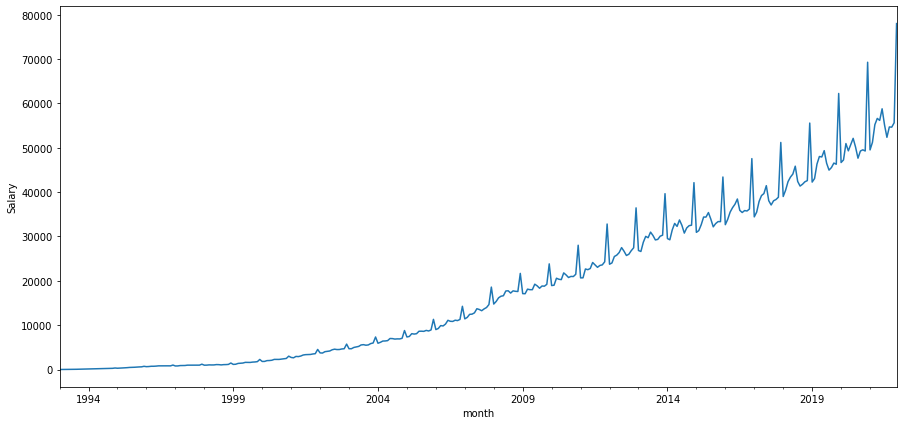

In [5]:
plt.figure(figsize(15, 7))
salary.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

Stationarity check and STL decomposition of series:

<Figure size 720x504 with 0 Axes>

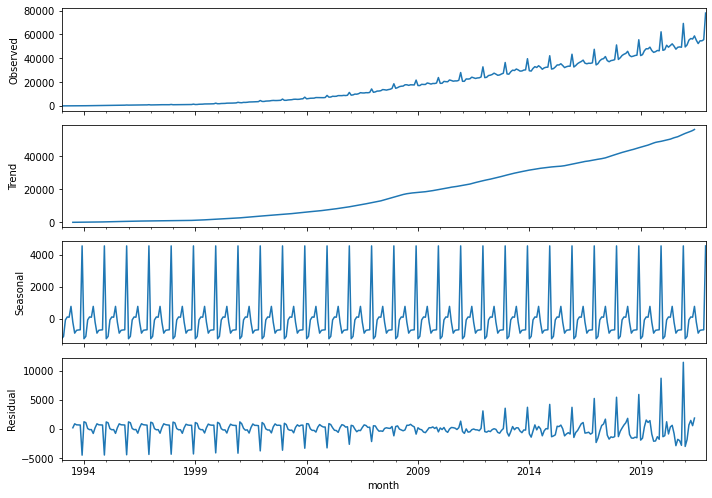

Dickey-Fuller test: p=1.000000


In [6]:
plt.figure(figsize(10,7))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
plt.show()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

We see a pronounced trend and seasonality, so the series is not stationary

### Dispersion stabilization

Let's make the Box-Cox transformation to stabilize the dispersion:

Optimal parameter of the Box-Cox transformation: 0.296773
Dickey-Fuller test: p=0.849038


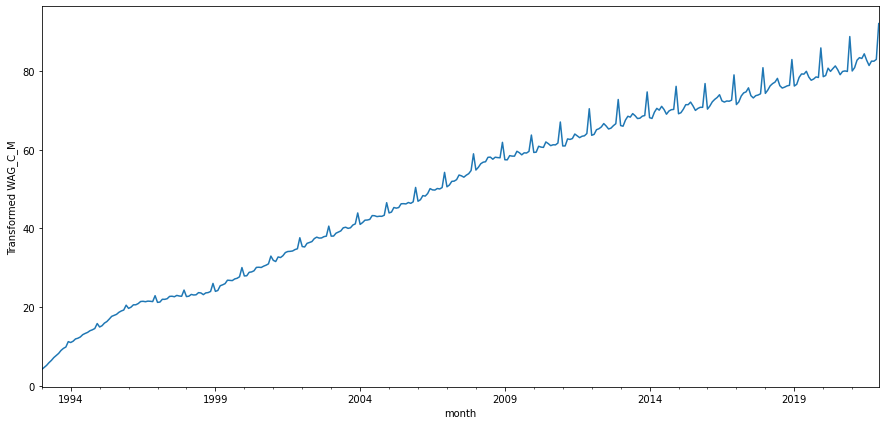

In [7]:
salary['WAG_C_M_'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.WAG_C_M_.plot()
plt.ylabel(u'Transformed WAG_C_M')
print("Optimal parameter of the Box-Cox transformation: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_)[1])


### Stationarity
The Dickey-Fuller criterion confirms the non-stationarity hypothesis. Let's try seasonal differentiation; let's do STL decomposition on the differentiated series and check the stationarity:

Dickey-Fuller test: p=0.093333


<Figure size 1080x720 with 0 Axes>

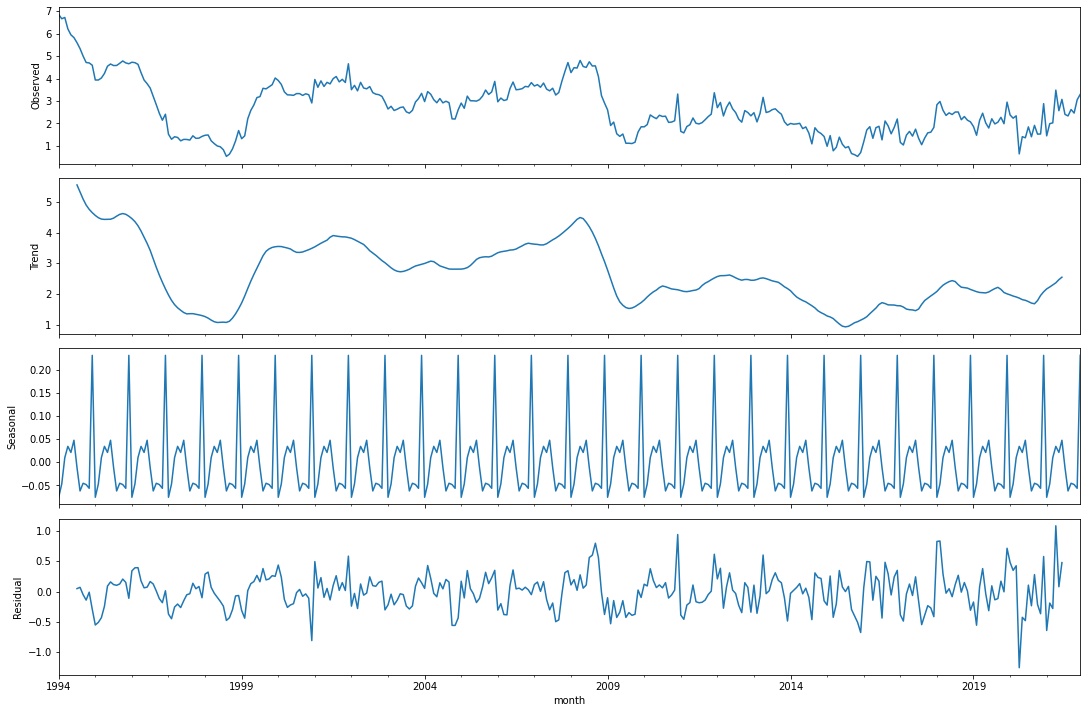

In [8]:
salary['WAG_C_M_diff'] = salary.WAG_C_M_ - salary.WAG_C_M_.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M_diff[12:]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_diff[12:])[1])

Much better! Let's try to add one more ordinary differentiation:

Dickey-Fuller test: p=0.006653


<Figure size 1080x720 with 0 Axes>

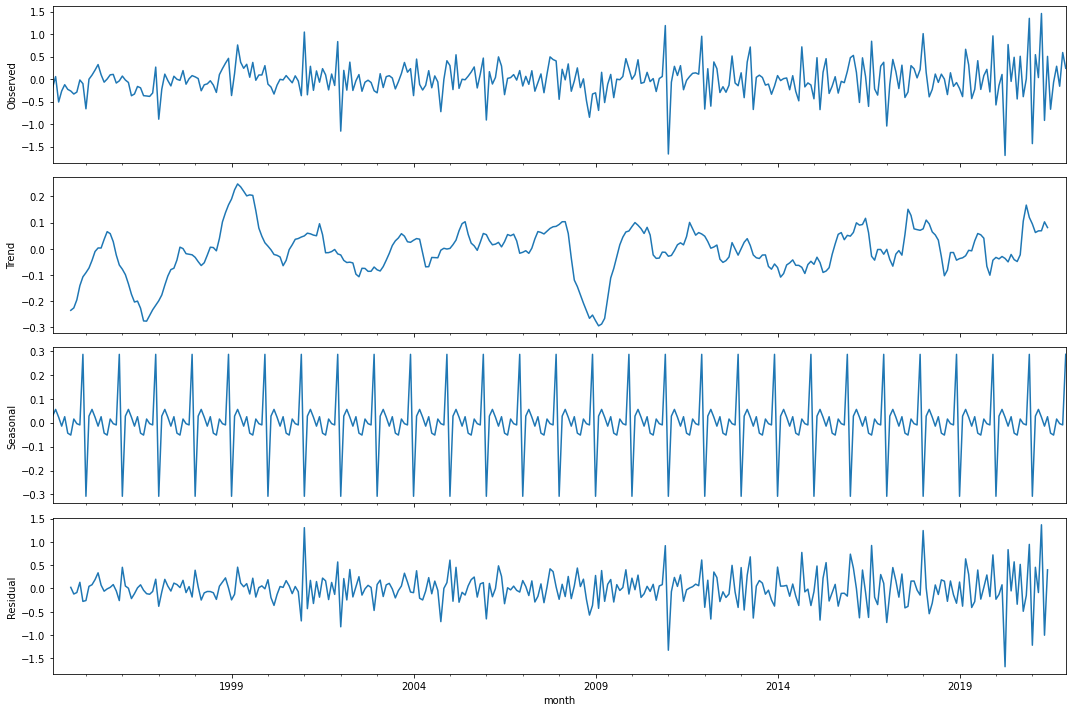

In [9]:
salary['WAG_C_M_diff2'] = salary.WAG_C_M_diff - salary.WAG_C_M_diff.shift(1)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M_diff2[13:]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_diff2[13:])[1])

The hypothesis of non-stationarity is rejected, and visually the series looks better - there is no longer a trend.

## Model selection
Let's look at the ACF and PACF of the resulting series:

In [10]:
warnings.filterwarnings('ignore')

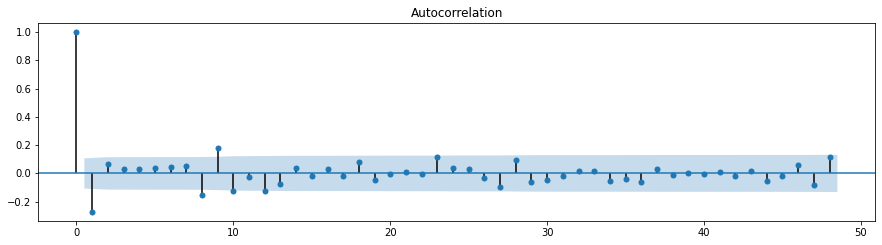

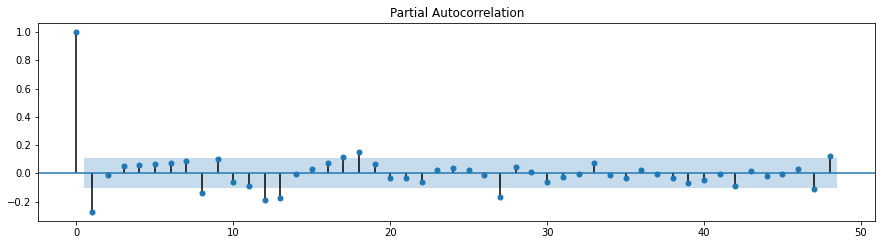

In [11]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.WAG_C_M_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.WAG_C_M_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Initial guesses: Q=0, q=1, P=1, p=1

Q - the value of the last significant seasonal lag on the autocorrelogram.
q - the value of the last significant non-seasonal lag on the autocorrelogram.
P is the value of the last significant seasonal lag on the partial autocorrelogram.
p is the value of the last significant non-seasonal lag, smaller than the period values, on the partial autocorrelogram.

In [12]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [13]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [14]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(salary.WAG_C_M_, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)    
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 2.04 s, sys: 1.63 s, total: 3.67 s
Wall time: 1.95 s


In [15]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters         aic
5  (1, 0, 1, 0)  277.684063
7  (1, 1, 1, 0)  279.292927
3  (0, 1, 1, 0)  279.533462
4  (1, 0, 0, 0)  286.695074
6  (1, 1, 0, 0)  288.676421


In [16]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           WAG_C_M_   No. Observations:                  348
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -135.842
Date:                            Tue, 22 Mar 2022   AIC                            277.684
Time:                                    12:41:24   BIC                            289.126
Sample:                                01-01-1993   HQIC                           282.246
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3006      0.041     -7.413      0.000      -0.380      -0.221
ar.S.L12      -0.1917      0.035   

Her residuals:

Student's criterion: p=0.387760
Dickey-Fuller test: p=0.023291


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lags = lags.astype(np.float)


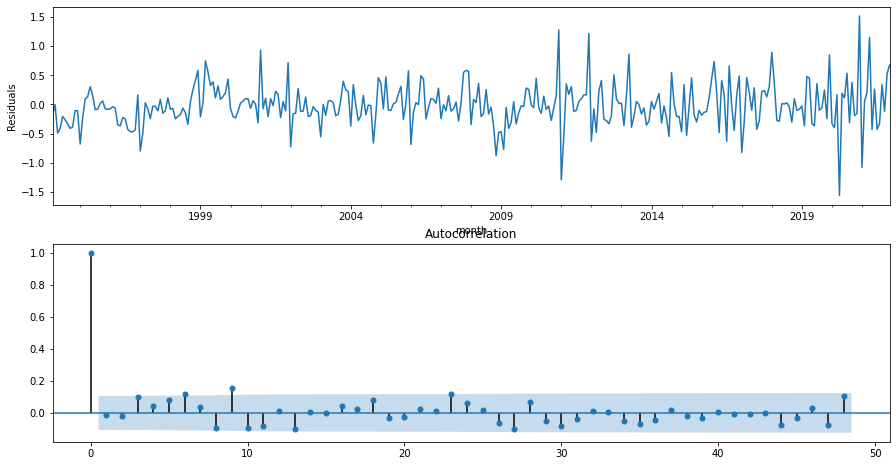

In [17]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's criterion: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Student's criterion: p = 0.387759 > 0.05 - residuals unbiased

Dickey-Fuller test: p = 0.023291 < 0.05 - residuals are stationary

Ljung-Box test: p > 0.05 - residuals are not autocorrelated

Let's see how well the model describes the data:

In [18]:
def invboxcox(y, lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

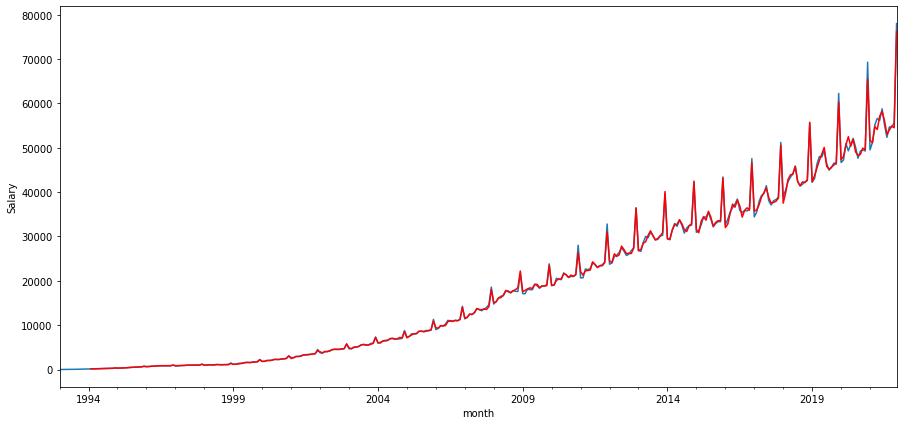

In [19]:
salary['model'] = invboxcox(best_model.fittedvalues,lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

## Predictions

In [20]:
warnings.filterwarnings('ignore')
best_model.predict(start=349, end=349 + 24)

2022-02-01    84.176493
2022-03-01    86.046016
2022-04-01    86.415485
2022-05-01    86.387980
2022-06-01    87.466003
2022-07-01    85.959146
2022-08-01    84.645239
2022-09-01    85.693277
2022-10-01    85.705817
2022-11-01    86.050999
2022-12-01    95.100708
2023-01-01    86.467140
2023-02-01    87.264905
2023-03-01    89.138302
2023-04-01    89.560541
2023-05-01    89.499605
2023-06-01    90.596118
2023-07-01    89.064710
2023-08-01    87.748255
2023-09-01    88.806811
2023-10-01    88.813555
2023-11-01    89.180445
2023-12-01    98.238992
2024-01-01    89.609993
2024-02-01    90.405592
Freq: MS, dtype: float64

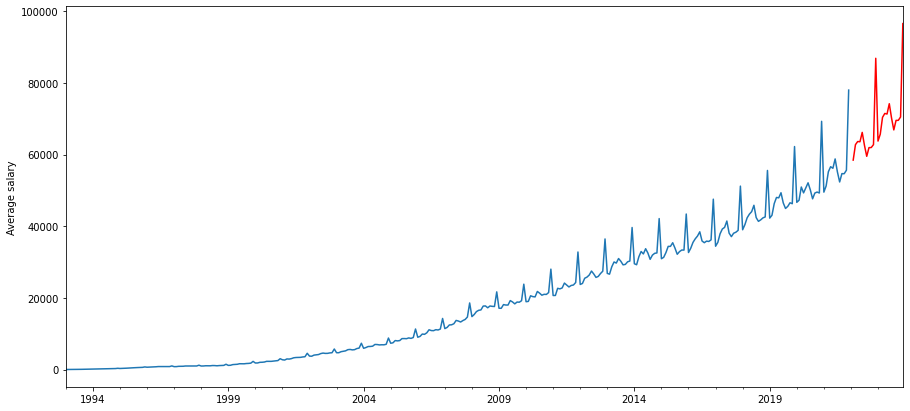

In [21]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2022-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=349, end=349 + 24), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Average salary')
pylab.show()